# 🫀 Prédiction du Risque de Maladie Cardiaque avec PySpark ML

Ce notebook suit un pipeline complet de Machine Learning pour prédire la présence d'une maladie cardiovasculaire à partir de données médicales.

**Étapes principales :**
1. Préparation de l'environnement
2. Chargement et exploration des données
3. Nettoyage et recodage
4. Analyse exploratoire (EDA)
5. Feature engineering et preprocessing
6. Construction du pipeline ML
7. Entraînement et évaluation des modèles
8. Interprétation et sauvegarde du modèle

## 1. Préparation de l'environnement

In [134]:
# Installer PySpark (si besoin)
!pip install pyspark

In [135]:
# Importer les bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [136]:
# Créer une session Spark
spark = SparkSession.builder.appName("Heart Disease Prediction").getOrCreate()
print("Spark Version:", spark.version)


Spark Version: 3.5.1


## 2. Chargement et exploration des données

In [137]:
# # Uploader le fichier CSV depuis votre ordinateur
# from google.colab import files
# uploaded = files.upload()  # Sélectionnez heart-disease.csv


In [138]:
# Charger le CSV dans un DataFrame PySpark
df = spark.read.csv("heart-disease.csv", header=True, inferSchema=True)
df.printSchema()  # Afficher la structure
df.show(5)        # Afficher les 5 premières lignes
print(f'Nombre total de lignes: {df.count()}')
df.describe().show()


root
 |-- ID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Angina: double (nullable = true)
 |-- Blood_Pressure: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Glycemia: double (nullable = true)
 |-- ECG: double (nullable = true)
 |-- Heart_Rate: double (nullable = true)
 |-- Angina_After_Sport: double (nullable = true)
 |-- ECG_Angina: double (nullable = true)
 |-- ECG_Slope: double (nullable = true)
 |-- Fluoroscopy: string (nullable = true)
 |-- Thalassaemia: string (nullable = true)
 |-- Disease: integer (nullable = true)

+---+----+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
| ID| Age|Sex|Angina|Blood_Pressure|Cholesterol|Glycemia|ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|Thalassaemia|Disease|
+---+----+---+------+--------------+-----------+--------+---+----------+------------------+--

In [139]:
# from pyspark.sql.functions import col

# 1️⃣ Identify string columns only
string_cols = [c for (c, dtype) in df.dtypes if dtype == "string" and c != "ID"]

# 2️⃣ Count '?' per column
print("🔍 Nombre de '?' par colonne :")
for c in string_cols:
    count_q = df.filter(col(c) == "?").count()
    print(f"Colonne {c}: {count_q} valeurs '?'")

# 3️⃣ Remove rows that contain '?' in ANY string column
rows_before = df.count()

if string_cols:
    condition = " AND ".join([f"{c} != '?'" for c in string_cols])
    df = df.filter(condition)

rows_after = df.count()
rows_removed = rows_before - rows_after

print(f"✅ Lignes contenant '?' supprimées : {rows_removed}")
print(f"📊 Lignes restantes : {rows_after}")



🔍 Nombre de '?' par colonne :
Colonne Fluoroscopy: 4 valeurs '?'
Colonne Thalassaemia: 2 valeurs '?'
✅ Lignes contenant '?' supprimées : 6
📊 Lignes restantes : 297


## 3. Nettoyage et recodage des variables

In [140]:
# Supprimer les lignes avec valeurs manquantes
df_clean = df.dropna()
print(f'Lignes après nettoyage: {df_clean.count()}')

# Recoder Sex (0/1 → Female/Male) and replace original column
df_clean = df_clean.withColumn("Sex", when(col("Sex") == 0, "Female").otherwise("Male"))
# Recoder Angina (1/2/3/4 → labels) and replace original column
df_clean = df_clean.withColumn("Angina", when(col("Angina") == 1, "Stable_Angina").when(col("Angina") == 2, "Unstable_Angina").when(col("Angina") == 3, "Other_Pains").otherwise("Asymptomatic"))
# Recoder Glycemia (0/1 → Less/More than 120 mg/dl) and replace original column
df_clean = df_clean.withColumn("Glycemia", when(col("Glycemia") == 0, "Less than 120 mg/dl").otherwise("More than 120 mg/dl"))
# Recoder ECG (0/1/2 → Normal/Anomalies/Hypertrophy) and replace original column
df_clean = df_clean.withColumn("ECG", when(col("ECG") == 0, "Normal").when(col("ECG") == 1, "Anomalies").otherwise("Hypertrophy"))
# Recoder Angina_After_Sport (0/1 → no/yes) and replace original column
df_clean = df_clean.withColumn("Angina_After_Sport", when(col("Angina_After_Sport") == 0, "no").otherwise("yes"))
# Recoder ECG_Slope (1/2/3 → Rising/Stable/Falling) and replace original column
df_clean = df_clean.withColumn("ECG_Slope", when(col("ECG_Slope") == 1, "Rising").when(col("ECG_Slope") == 2, "Stable").otherwise("Falling"))
# Recoder Fluoroscopy (0/1/2/3 → No anomaly/Low/Medium/High) and replace original column
df_clean = df_clean.withColumn("Fluoroscopy", when(col("Fluoroscopy") == 0, "No anomaly").when(col("Fluoroscopy") == 1, "Low").when(col("Fluoroscopy") == 2, "Medium").otherwise("High"))
# Recoder Thalassaemia (3/6/7 → No/Under control/Unstable) and replace original column
df_clean = df_clean.withColumn("Thalassaemia", when(col("Thalassaemia") == 3, "No").when(col("Thalassaemia") == 6, "Thalassaemia under control").otherwise("Unstable Thalassaemia"))
# Convertir Disease en binaire (0 = sain, 1-4 = malade) and replace original column
df_clean = df_clean.withColumn("Disease", when(col("Disease") == 0,"no").otherwise("yes"))

df_clean.show(5)



Lignes après nettoyage: 297
+---+----+------+---------------+--------------+-----------+-------------------+-----------+----------+------------------+----------+---------+-----------+--------------------+-------+
| ID| Age|   Sex|         Angina|Blood_Pressure|Cholesterol|           Glycemia|        ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|        Thalassaemia|Disease|
+---+----+------+---------------+--------------+-----------+-------------------+-----------+----------+------------------+----------+---------+-----------+--------------------+-------+
|  1|63.0|  Male|  Stable_Angina|         145.0|      233.0|More than 120 mg/dl|Hypertrophy|     150.0|                no|       2.3|  Falling| No anomaly|Thalassaemia unde...|     no|
|  2|67.0|  Male|   Asymptomatic|         160.0|      286.0|Less than 120 mg/dl|Hypertrophy|     108.0|               yes|       1.5|   Stable|       High|                  No|    yes|
|  3|67.0|  Male|   Asymptomatic|         120.0

## 4. Analyse exploratoire (EDA)

In [141]:
df_clean.printSchema()  # Afficher la structure

# Définir les colonnes catégorielles et numériques
categorical_cols = ['Sex', 'Angina', 'Glycemia', 'ECG', 'Angina_After_Sport', 'ECG_Slope', 'Fluoroscopy', 'Thalassaemia']
numeric_cols = ['Age', 'Blood_Pressure', 'Cholesterol', 'Heart_Rate', 'ECG_Angina']



# Statistiques descriptives pour les variables numériques
print("\n📊 Statistiques descriptives pour les variables numériques:")
df_clean.select(numeric_cols).describe().show()

# Statistiques descriptives pour les variables catégorielles (distribution des valeurs)
print("\n📊 Distribution des variables catégorielles:")
for col_name in categorical_cols:
    print(f"\nDistribution de '{col_name}':")
    df_clean.groupBy(col_name).count().show()


# Distribution de la variable cible
print("\n📊 Distribution de la variable cible 'Disease':")
df_clean.groupBy("Disease").count().show()



root
 |-- ID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Sex: string (nullable = false)
 |-- Angina: string (nullable = false)
 |-- Blood_Pressure: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Glycemia: string (nullable = false)
 |-- ECG: string (nullable = false)
 |-- Heart_Rate: double (nullable = true)
 |-- Angina_After_Sport: string (nullable = false)
 |-- ECG_Angina: double (nullable = true)
 |-- ECG_Slope: string (nullable = false)
 |-- Fluoroscopy: string (nullable = false)
 |-- Thalassaemia: string (nullable = false)
 |-- Disease: string (nullable = false)


📊 Statistiques descriptives pour les variables numériques:
+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|              Age|    Blood_Pressure|       Cholesterol|        Heart_Rate|        ECG_Angina|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  co

This indicates that the dataset is relatively balanced, meaning the number of cases with and without the disease are somewhat similar. This is good for training a classification model, as highly imbalanced datasets can sometimes lead to models that are biased towards the majority class.

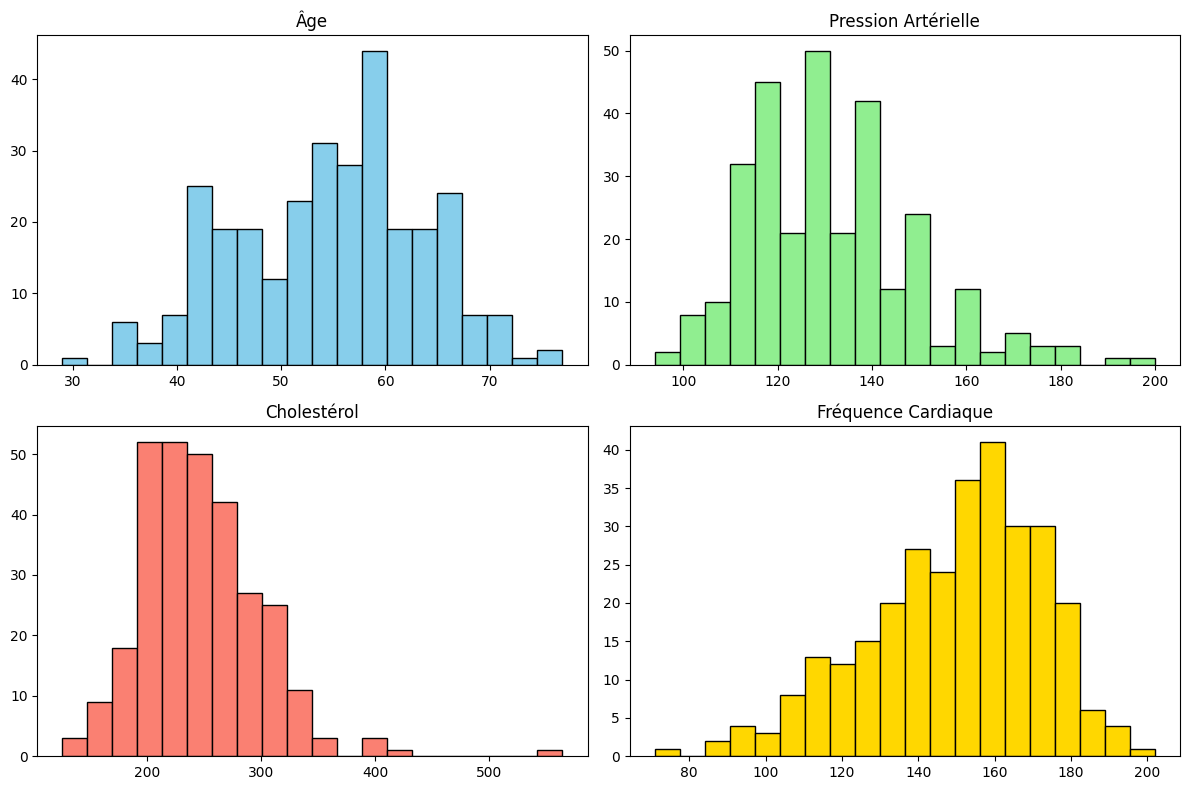

In [142]:
# Visualisation des distributions (histogrammes)
df_pandas = df_clean.toPandas()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].hist(df_pandas['Age'], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title("Âge")
axes[0,1].hist(df_pandas['Blood_Pressure'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title("Pression Artérielle")
axes[1,0].hist(df_pandas['Cholesterol'], bins=20, color='salmon', edgecolor='black')
axes[1,0].set_title("Cholestérol")
axes[1,1].hist(df_pandas['Heart_Rate'], bins=20, color='gold', edgecolor='black')
axes[1,1].set_title("Fréquence Cardiaque")
plt.tight_layout()
plt.show()



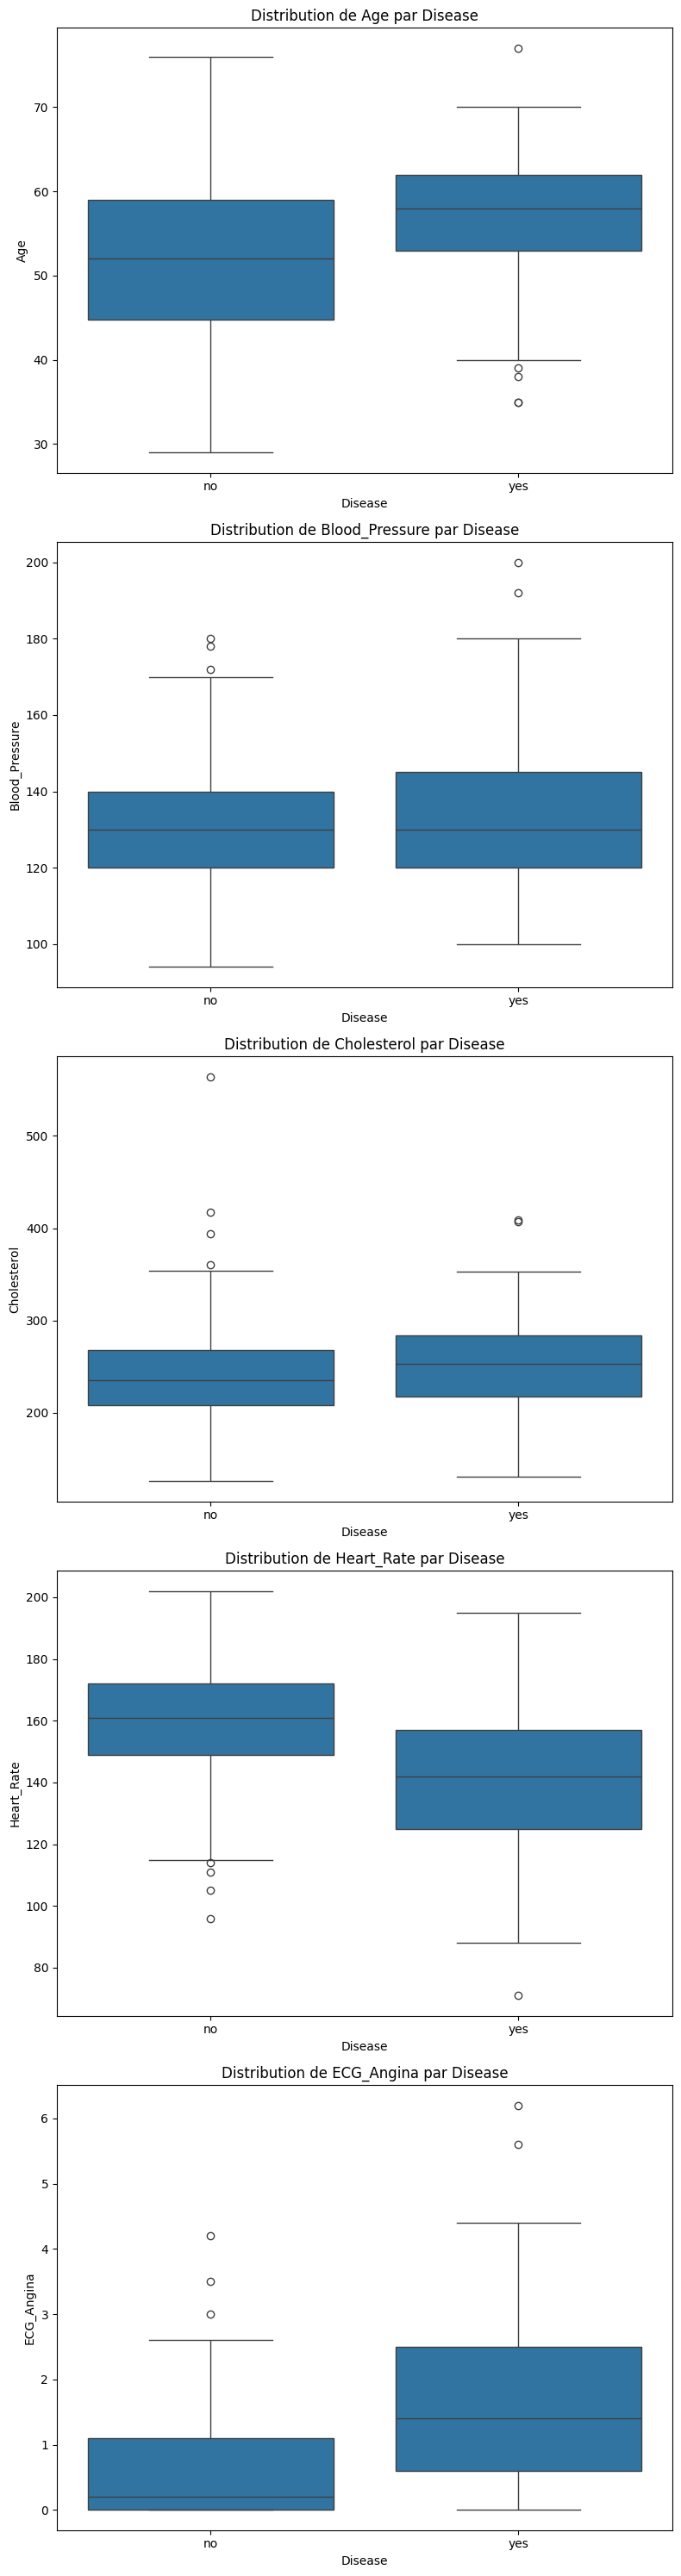

In [143]:
# Visualisation des distributions (boxplots) pour les variables numériques par 'Disease'


df_pandas = df_clean.toPandas()

fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(8, 6 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Disease', y=col, data=df_pandas, ax=axes[i])
    axes[i].set_title(f'Distribution de {col} par Disease')
    axes[i].set_xlabel('Disease')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


## 5. Feature engineering et preprocessing

In [144]:
# StringIndexer : transforme texte → indices numériques
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name+"_idx", handleInvalid="keep")
            for col_name in categorical_cols]

# OneHotEncoder : transforme indices → vecteurs binaires
encoders = [OneHotEncoder(inputCol=col_name+"_idx", outputCol=col_name+"_encoded")
            for col_name in categorical_cols]



In [145]:
#Normalisation ou standardisation des variables numériques.
# VectorAssembler pour regrouper les colonnes numériques avant le scaler
assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")


# StandardScaler : standardise les valeurs (moyenne=0, écart-type=1)
scaler = StandardScaler(inputCol="numeric_features", outputCol="numeric_scaled", withMean=True, withStd=True)


In [146]:

from pyspark.sql.functions import col
# Création des nouvelles features combinées
df_clean = df_clean.withColumn('Cholesterol_Blood_Pressure_Ratio', col('Cholesterol') / col('Blood_Pressure'))
df_clean = df_clean.withColumn('Age_BP_Interaction', col('Age') * col('Blood_Pressure'))
df_clean = df_clean.withColumn('BP_HeartRate_Interaction', col('Blood_Pressure') * col('Heart_Rate'))

# Mise à jour de la liste des colonnes numériques
numeric_cols += ['Cholesterol_Blood_Pressure_Ratio', 'Age_BP_Interaction', 'BP_HeartRate_Interaction']

print("📋 Colonnes du DataFrame df_clean :")
print(df_clean.columns)


📋 Colonnes du DataFrame df_clean :
['ID', 'Age', 'Sex', 'Angina', 'Blood_Pressure', 'Cholesterol', 'Glycemia', 'ECG', 'Heart_Rate', 'Angina_After_Sport', 'ECG_Angina', 'ECG_Slope', 'Fluoroscopy', 'Thalassaemia', 'Disease', 'Cholesterol_Blood_Pressure_Ratio', 'Age_BP_Interaction', 'BP_HeartRate_Interaction']


## 6. Construction du pipeline ML

In [147]:
# 🔹 VectorAssembler final pour assembler toutes les features
encoded_cols = [col + "_encoded" for col in categorical_cols]
numeric_scaled_cols = ["numeric_scaled"]  # les nouvelles features combinées seront ajoutées dans le pipeline
final_input_cols = encoded_cols + ["numeric_scaled"] + ['Cholesterol_Blood_Pressure_Ratio',
                                                         'Age_BP_Interaction',
                                                         'BP_HeartRate_Interaction']

assembler = VectorAssembler(inputCols=final_input_cols, outputCol="features")


In [148]:
# 🔹 Indexer pour la colonne label Disease
label_indexer = StringIndexer(inputCol="Disease", outputCol="label", handleInvalid="keep")
df_clean = label_indexer.fit(df_clean).transform(df_clean)

In [149]:
# Définition des modèles : Logistic Regression, Random Forest, Gradient Boosted Trees.
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
print("✅ Modèle défini : Logistic Regression")

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10,)
print("✅ Modèle défini : Random Forest Classifier")

# Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)
print("✅ Modèle défini : Gradient Boosted Trees Classifier")

# Résumé log
print("\n📌 Tous les modèles sont définis et prêts pour l'entraînement !")


✅ Modèle défini : Logistic Regression
✅ Modèle défini : Random Forest Classifier
✅ Modèle défini : Gradient Boosted Trees Classifier

📌 Tous les modèles sont définis et prêts pour l'entraînement !


In [150]:
# ---------------------------------------------------------
# 5️⃣ Création d'un pipeline complet (exemple avec Logistic Regression)
# ---------------------------------------------------------
pipeline_lr = Pipeline(stages=indexers + encoders + [assembler_numeric, scaler, assembler, lr])
print("✅ Pipeline complet avec Logistic Regression créé")

# Tu peux créer un pipeline similaire pour Random Forest et GBT
pipeline_rf = Pipeline(stages=indexers + encoders + [assembler_numeric, scaler, assembler, rf])
print("✅ Pipeline complets pour Random Forest ")
pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler_numeric, scaler, assembler, gbt])
print("✅ Pipeline complet pour  GBT créé")

✅ Pipeline complet avec Logistic Regression créé
✅ Pipeline complets pour Random Forest 
✅ Pipeline complet pour  GBT créé


## 7. Entraînement et évaluation des modèles

In [151]:
# Split train/test
train_df, test_df = df_clean.randomSplit([0.7, 0.3], seed=42)
print(f'Train: {train_df.count()} | Test: {test_df.count()}')
train_df.groupBy('Disease').count().show()
test_df.groupBy('Disease').count().show()


Train: 220 | Test: 77
+-------+-----+
|Disease|count|
+-------+-----+
|     no|  128|
|    yes|   92|
+-------+-----+

+-------+-----+
|Disease|count|
+-------+-----+
|     no|   32|
|    yes|   45|
+-------+-----+



In [152]:
# Entraîner
# Logistic Regression
model_lr = pipeline_lr.fit(train_df)

# Random Forest
model_rf = pipeline_rf.fit(train_df)

# Gradient Boosted Trees
model_gbt = pipeline_gbt.fit(train_df)

In [133]:
# -----------------------------
# 1️⃣ Cross-Validation pour chaque modèle
# -----------------------------

# Évaluateur commun
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# 🔹 Logistic Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,
                       estimatorParamMaps=paramGrid_lr,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

cv_model_lr = cv_lr.fit(train_df)

# 🔹 Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

cv_model_rf = cv_rf.fit(train_df)

# 🔹 Gradient Boosted Trees
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,
                        estimatorParamMaps=paramGrid_gbt,
                        evaluator=evaluator,
                        numFolds=3,
                        parallelism=2)

cv_model_gbt = cv_gbt.fit(train_df)


In [153]:
# -----------------------------
# 2️⃣ Prédictions sur test set
# -----------------------------
predictions_lr  = cv_model_lr.transform(test_df)
predictions_rf  = cv_model_rf.transform(test_df)
predictions_gbt = cv_model_gbt.transform(test_df)

In [154]:
# -----------------------------
# 3️⃣ Calcul des métriques
# -----------------------------
def compute_metrics(predictions, model_name):
    evaluator_acc  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

    acc  = evaluator_acc.evaluate(predictions)
    f1   = evaluator_f1.evaluate(predictions)
    prec = evaluator_prec.evaluate(predictions)
    rec  = evaluator_rec.evaluate(predictions)

    print(f"✅ {model_name} | Accuracy: {acc:.3f} | F1-score: {f1:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}")

compute_metrics(predictions_lr, "Logistic Regression")
compute_metrics(predictions_rf, "Random Forest")
compute_metrics(predictions_gbt, "GBT")

✅ Logistic Regression | Accuracy: 0.844 | F1-score: 0.845 | Precision: 0.865 | Recall: 0.844
✅ Random Forest | Accuracy: 0.818 | F1-score: 0.819 | Precision: 0.848 | Recall: 0.818
✅ GBT | Accuracy: 0.805 | F1-score: 0.806 | Precision: 0.830 | Recall: 0.805



📊 Matrice de confusion - Logistic Regression
prediction  0.0  1.0
label               
0.0          30    2
1.0          10   35


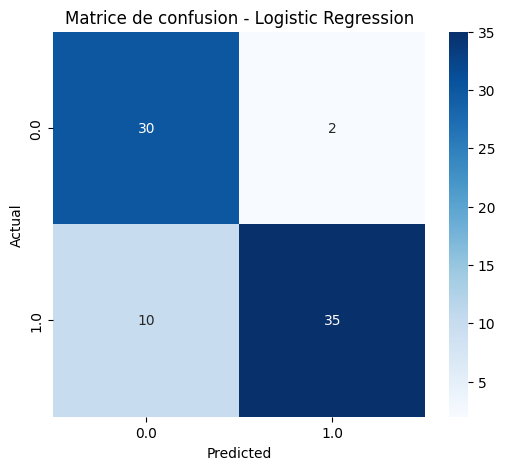


📊 Matrice de confusion - Random Forest
prediction  0.0  1.0
label               
0.0          30    2
1.0          12   33


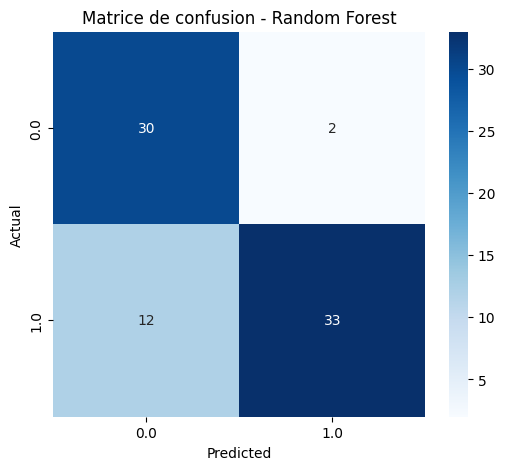


📊 Matrice de confusion - GBT
prediction  0.0  1.0
label               
0.0          29    3
1.0          12   33


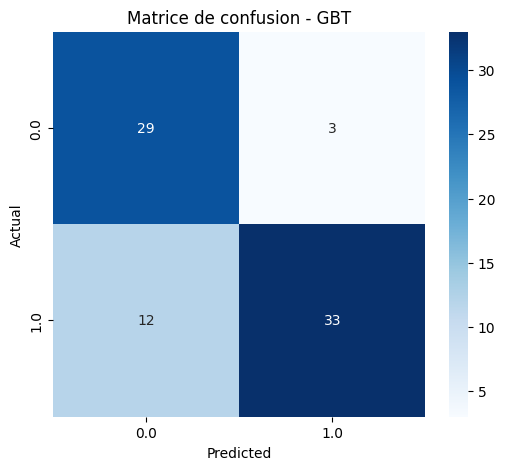

In [155]:
# -----------------------------
# 4️⃣ Matrice de confusion et visualisation
# -----------------------------
def plot_confusion_matrix(predictions, model_name):
    conf_mat = predictions.groupBy("label", "prediction").count().toPandas()
    conf_mat_pivot = conf_mat.pivot(index="label", columns="prediction", values="count").fillna(0)

    print(f"\n📊 Matrice de confusion - {model_name}")
    print(conf_mat_pivot)

    plt.figure(figsize=(6,5))
    sns.heatmap(conf_mat_pivot, annot=True, fmt='g', cmap="Blues")
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(predictions_lr, "Logistic Regression")
plot_confusion_matrix(predictions_rf, "Random Forest")
plot_confusion_matrix(predictions_gbt, "GBT")

## 8. Interprétation et sauvegarde du modèle


🌟 Feature importances - Random Forest
                             Feature  Importance
2                   Glycemia_encoded    0.106556
11          BP_HeartRate_Interaction    0.041205
0                        Sex_encoded    0.026270
1                     Angina_encoded    0.016853
3                        ECG_encoded    0.014382
5                  ECG_Slope_encoded    0.010068
6                Fluoroscopy_encoded    0.007463
9   Cholesterol_Blood_Pressure_Ratio    0.005585
4         Angina_After_Sport_encoded    0.004964
7               Thalassaemia_encoded    0.004591
8                     numeric_scaled    0.003845
10                Age_BP_Interaction    0.000718


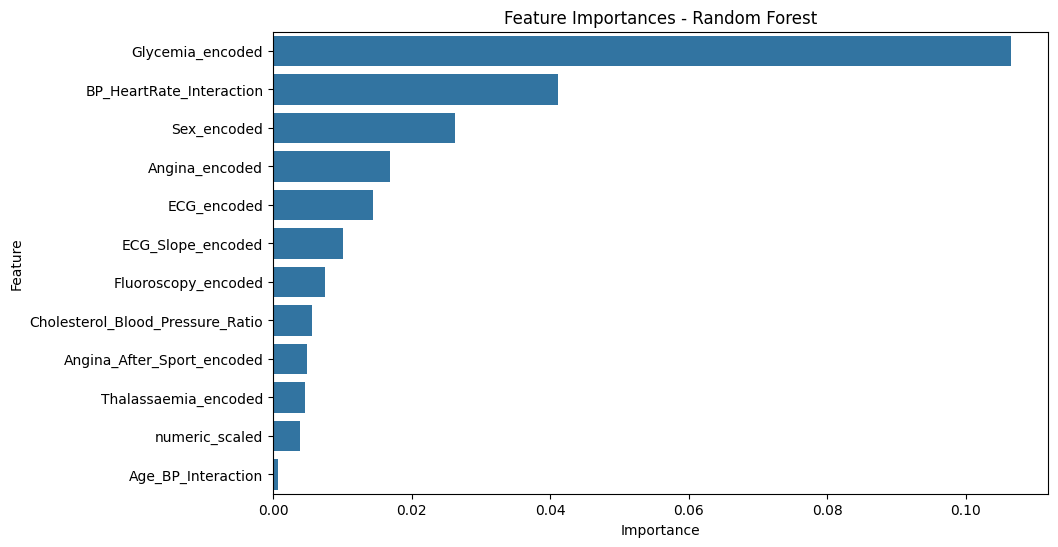


🌟 Feature importances - GBT
                             Feature  Importance
2                   Glycemia_encoded    0.067466
11          BP_HeartRate_Interaction    0.065465
0                        Sex_encoded    0.040694
6                Fluoroscopy_encoded    0.007555
8                     numeric_scaled    0.006413
9   Cholesterol_Blood_Pressure_Ratio    0.004619
3                        ECG_encoded    0.000000
1                     Angina_encoded    0.000000
7               Thalassaemia_encoded    0.000000
5                  ECG_Slope_encoded    0.000000
4         Angina_After_Sport_encoded    0.000000
10                Age_BP_Interaction    0.000000


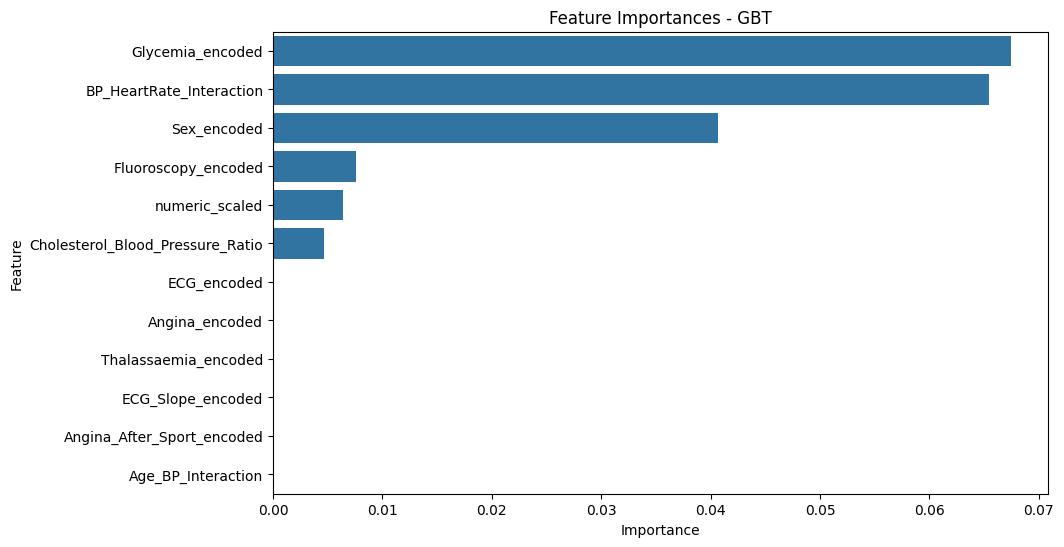

In [156]:
from pyspark.ml.linalg import DenseVector

# 🔹 Fonction pour afficher l'importance des features
def show_feature_importances(model, feature_names, model_name):
    # Extraire l'objet MLlib du pipeline
    tree_model = model.stages[-1]  # le dernier stage est le modèle (RF ou GBT)
    importances = tree_model.featureImportances

    # Convertir en DataFrame Pandas
    feature_importance_list = list(zip(feature_names, importances))
    df_importance = pd.DataFrame(feature_importance_list, columns=["Feature", "Importance"])
    df_importance = df_importance.sort_values(by="Importance", ascending=False)

    print(f"\n🌟 Feature importances - {model_name}")
    print(df_importance)

    # Graphique
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=df_importance)
    plt.title(f"Feature Importances - {model_name}")
    plt.show()

# 🔹 Liste des features correspondant à la colonne 'features'
# On utilise la même liste que pour VectorAssembler
feature_names = final_input_cols  # ['Sex_encoded', 'Angina_encoded', ..., 'numeric_scaled', 'Cholesterol_Blood_Pressure_Ratio', ...]

# 🔹 Afficher pour Random Forest et GBT
show_feature_importances(cv_model_rf.bestModel, feature_names, "Random Forest")
show_feature_importances(cv_model_gbt.bestModel, feature_names, "GBT")


In [159]:
#  sauvegarder le pipeline Logistic Regression
model_lr.save("pipeline_lr_model.")

# De même pour RF et GBT
model_rf.save("pipeline_rf_model.")
model_gbt.save("pipeline_gbt_model.")

print("✅ Pipelines sauvegardés avec succès !")

✅ Pipelines sauvegardés avec succès !


## 9 -Interprétation

In [160]:
from pyspark.ml.pipeline import PipelineModel

# Charger le pipeline LR
loaded_pipeline_lr = PipelineModel.load("pipeline_lr_model")

# Pour RF et GBT
loaded_pipeline_rf = PipelineModel.load("pipeline_rf_model")
loaded_pipeline_gbt = PipelineModel.load("pipeline_gbt_model")


In [161]:
from pyspark.sql import Row
from pyspark.sql.functions import col

# 🔹 1. Create new observation
new_data = [
    Row(
        Age=55,
        Sex="Male",
        Angina="Stable_Angina",
        Blood_Pressure=140,
        Cholesterol=210,
        Glycemia="High",
        ECG="Normal",
        Heart_Rate=85,
        Angina_After_Sport="No",
        ECG_Angina=2.3,
        ECG_Slope="Flat",
        Fluoroscopy="Normal",
        Thalassaemia="No"
    )
]

new_df = spark.createDataFrame(new_data)

# 🔹 2. Recreate the engineered features (same formulas as training)
new_df = (
    new_df
    .withColumn('Cholesterol_Blood_Pressure_Ratio', col('Cholesterol') / col('Blood_Pressure'))
    .withColumn('Age_BP_Interaction', col('Age') * col('Blood_Pressure'))
    .withColumn('BP_HeartRate_Interaction', col('Blood_Pressure') * col('Heart_Rate'))
)

# 🔹 3. Predict using the pipeline
predictions_new = loaded_pipeline_lr.transform(new_df)

# 🔹 4. Show the results
predictions_new.select("features", "prediction", "probability").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------------------------------------------+
|features                                                                                                                                                                   |prediction|probability                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------------------------------------------+
|(31,[0,5,8,20,23,24,25,26,27,28,29,30],[1.0,1.0,1.0,1.0,0.12052593713884788,0.5786764308207332,-0.7080997054403225,-2.80361396178614,1.220691356009229,1.5,7700.0,11900.0])|0.0       |[0.5484531524494273,0.44811435314862863,0.003432494401944118]|
+-----------

In [162]:
from pyspark.sql import Row
from pyspark.sql.functions import col

# 🔹 1. Create 3 "sick" (high-risk) patients
new_data = [
    Row(
        Age=67,
        Sex="Male",
        Angina="Asymptomatic",
        Blood_Pressure=160,
        Cholesterol=280,
        Glycemia="High",
        ECG="Hypertrophy",
        Heart_Rate=110,
        Angina_After_Sport="Yes",
        ECG_Angina=2.6,
        ECG_Slope="Falling",
        Fluoroscopy="High",
        Thalassaemia="Unstable"
    ),
    Row(
        Age=62,
        Sex="Male",
        Angina="Unstable_Angina",
        Blood_Pressure=150,
        Cholesterol=290,
        Glycemia="High",
        ECG="Hypertrophy",
        Heart_Rate=130,
        Angina_After_Sport="Yes",
        ECG_Angina=3.1,
        ECG_Slope="Falling",
        Fluoroscopy="Medium",
        Thalassaemia="Unstable"
    ),
    Row(
        Age=70,
        Sex="Female",
        Angina="Asymptomatic",
        Blood_Pressure=170,
        Cholesterol=310,
        Glycemia="High",
        ECG="Abnormal",
        Heart_Rate=120,
        Angina_After_Sport="Yes",
        ECG_Angina=3.4,
        ECG_Slope="Falling",
        Fluoroscopy="High",
        Thalassaemia="Unstable"
    )
]

# 🔹 2. Convert to DataFrame
new_df = spark.createDataFrame(new_data)

# 🔹 3. Recreate engineered features (same as in training)
new_df = (
    new_df
    .withColumn('Cholesterol_Blood_Pressure_Ratio', col('Cholesterol') / col('Blood_Pressure'))
    .withColumn('Age_BP_Interaction', col('Age') * col('Blood_Pressure'))
    .withColumn('BP_HeartRate_Interaction', col('Blood_Pressure') * col('Heart_Rate'))
)

# 🔹 4. Predict with your trained pipeline
predictions_new = loaded_pipeline_lr.transform(new_df)

# 🔹 5. Optional: make the prediction readable
from pyspark.sql.functions import when

predictions_new = predictions_new.withColumn(
    "Predicted_Disease",
    when(predictions_new["prediction"] == 1.0, "yes").otherwise("no")
)

# 🔹 6. Display results
predictions_new.select(
    "Age", "Sex", "Blood_Pressure", "Cholesterol", "Heart_Rate",
    "prediction", "Predicted_Disease", "probability"
).show(truncate=False)


+---+------+--------------+-----------+----------+----------+-----------------+--------------------------------------------------------------+
|Age|Sex   |Blood_Pressure|Cholesterol|Heart_Rate|prediction|Predicted_Disease|probability                                                   |
+---+------+--------------+-----------+----------+----------+-----------------+--------------------------------------------------------------+
|67 |Male  |160           |280        |110       |1.0       |yes              |[0.014989814454676868,0.9844271250172975,5.830605280257174E-4]|
|62 |Male  |150           |290        |130       |1.0       |yes              |[0.01995420903052963,0.9782962186530767,0.0017495723163937027]|
|70 |Female|170           |310        |120       |1.0       |yes              |[0.06873993749518752,0.9291910815917417,0.0020689809130708236]|
+---+------+--------------+-----------+----------+----------+-----------------+--------------------------------------------------------------+